In [1]:
# Simulate 10-stock prices for ~1 year and backtest the strategy:
# "Each week, buy the 3 stocks with the smallest decline (i.e., highest weekly return) over the *just-finished* week;
# rebalance weekly." We trade at the next Monday open, approximated here by Monday close (simple daily data).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from math import sqrt
import random

In [17]:
# Reproducibility
np.random.seed(42)
random.seed(42)

# 1) Generate business-day calendar for the last ~1 year (Stockholm timezone doesn't affect dates here)
end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.tseries.offsets.BDay(252)  # ~1 trading year
dates = pd.bdate_range(start=start_date, end=end_date)

# 2) Simulate 10 tickers with geometric random walks
tickers = [f"S{i}" for i in range(1, 11)]
n = len(dates)

# Random per-stock drifts (annualized) and volatilities to make it interesting
annual_drifts = np.random.uniform(-0.05, 0.15, size=len(tickers))   # -5% to +15%
annual_vols = np.random.uniform(0.15, 0.35, size=len(tickers))      # 15% to 35%

dt = 1/252
close = pd.DataFrame(index=dates, columns=tickers, dtype=float)

for i, t in enumerate(tickers):
    mu = annual_drifts[i]
    sigma = annual_vols[i]
    # Start prices around 50–150
    s0 = np.random.uniform(50, 150)
    # Daily returns for GBM: dS/S = mu*dt + sigma*sqrt(dt)*Z
    z = np.random.normal(size=n)
    r = (mu*dt) + sigma*np.sqrt(dt)*z
    price = s0 * np.exp(np.cumsum(r))
    close[t] = price

weekly_close = close.resample("W-FRI").last()
weekly_ret = weekly_close.pct_change()  # Friday-to-Friday return

In [18]:
# 4) Strategy: each Friday, select 3 stocks with highest weekly return (i.e., fell least / rose most),
# then hold them for the next week. Execute at the next Monday open; approximated here by Monday close.
# We track portfolio daily-valued using close prices.
initial_capital = 1_000_000.0
fee_bps = 5  # 5 bps per notional traded

# Determine rebalancing dates (Fridays) and corresponding holding windows (next Mon->next Fri)
rebal_dates = weekly_ret.index[1:]  # skip the first (no prior week to rank)
# Map each rebalance Friday to the next week's business-day range
calendar = close.index

In [19]:
def next_week_range(friday):
    # Next Monday (business day after Friday)
    idx = calendar.searchsorted(friday, side="right")  # friday should be in calendar due to resample 'last'
    # find the next business day index + 1
    if isinstance(idx, slice):
        idx = idx.stop - 1
    # Next business day:
    if idx + 1 >= len(calendar):
        return None
    start = calendar[idx + 1]
    # End: up to next Friday (inclusive) or until data ends
    # Find next Friday from 'start'
    week_end = (start + pd.offsets.Week(weekday=4))  # next Friday
    # Clip to available dates
    days = calendar[(calendar >= start) & (calendar <= week_end)]
    if len(days) == 0:
        return None
    return days

In [20]:
# Initialize portfolio state
cash = initial_capital
positions = pd.Series(0.0, index=tickers)  # shares
equity_curve = pd.Series(index=calendar, dtype=float)
holdings_history = []  # records of weekly picks
trade_log = []

In [21]:
# Prime: before first rebalance, we are in cash.
# Iterate through rebalance dates
def pick_names(weekly_row: pd.Series, k=3, mode="winners"):
    s = weekly_row.dropna()
    if mode == "winners":
        return s.nlargest(k).index.tolist()
    elif mode == "losers":
        return s.nsmallest(k).index.tolist()
    else:
        raise ValueError("mode must be 'winners' or 'losers'")



for fr in rebal_dates:
    # Picks based on last week's returns up to 'fr'
    weekly_r = weekly_ret.loc[fr].dropna()
    if weekly_r.empty:
        continue
    picks = pick_names(weekly_ret.loc[fr], k=3, mode="losers")

    
    # Holding window for next week
    days = next_week_range(fr)
    if days is None or len(days) == 0:
        continue
    
    # Rebalance at first day close (approximate next Monday open)
    d0 = days[0]
    prices = close.loc[d0]
    
    # Compute target equal-weight value per pick
    port_val = cash + (positions * prices).sum()
    target_weights = pd.Series(0.0, index=tickers)
    target_weights.loc[picks] = 1/3
    
    target_value = target_weights * port_val
    current_value = positions * prices
    delta_value = (target_value - current_value).reindex(tickers).fillna(0.0)
    
    # Convert to shares at current prices
    trade_shares = (delta_value / prices).fillna(0.0)
    # Round to whole shares
    trade_shares = trade_shares.round()
    # Notional traded and fees
    notional = (trade_shares.abs() * prices).sum()
    fees = notional * (fee_bps / 1e4)
    
    # Execute: update cash & positions
    cash -= (trade_shares * prices).sum() + fees
    positions += trade_shares
    
    trade_log.append({
        "date": d0,
        "action": "rebalance",
        "picks": picks,
        "notional_traded": float(notional),
        "fees": float(fees),
        "cash_after": float(cash)
    })
    holdings_history.append({"friday": fr, "week_start": d0, "picks": picks})
    
    # Value portfolio each day in holding window
    for d in days:
        equity_curve.loc[d] = cash + (positions * close.loc[d]).sum()

In [22]:
# Fill gaps before first trade and after last with mark-to-market (cash only before first)
# Forward-fill equity where missing during the year by carrying last known valuation
equity_curve.iloc[0] = initial_capital if pd.isna(equity_curve.iloc[0]) else equity_curve.iloc[0]
equity_curve = equity_curve.ffill()
equity_curve.name = "Equity"

In [23]:
# 5) Benchmark: equal-weight of all 10 stocks, daily-rebalanced to equal weight (for simplicity, no costs)
bench_weights = pd.DataFrame(1/len(tickers), index=close.index, columns=tickers)
bench_ret = (close.pct_change().fillna(0) * bench_weights).sum(axis=1)
bench_equity = (1 + bench_ret).cumprod() * initial_capital
bench_equity.name = "Benchmark_EQW"

In [24]:
# 6) Metrics
ret = equity_curve.pct_change().fillna(0)
bench_r = bench_equity.pct_change().fillna(0)

def max_drawdown(series):
    peak = series.cummax()
    dd = series / peak - 1
    return dd.min()

def annualize_return(series):
    total = series.iloc[-1]/series.iloc[0] - 1
    years = len(series)/252
    return (1+total)**(1/years) - 1 if years > 0 else np.nan

metrics = {
    "CAGR": annualize_return(equity_curve),
    "Vol_Ann": ret.std() * sqrt(252),
    "Sharpe_Ann": (ret.mean() / ret.std()) * sqrt(252) if ret.std() > 0 else np.nan,
    "MaxDD": max_drawdown(equity_curve),
    "Turnover_$": sum(t["notional_traded"] for t in trade_log),
    "Fees_$": sum(t["fees"] for t in trade_log),
    "Rebalance_Count": len(trade_log),
}
bench_metrics = {
    "CAGR_bench": annualize_return(bench_equity),
    "Vol_Ann_bench": bench_r.std() * sqrt(252),
    "Sharpe_Ann_bench": (bench_r.mean()/bench_r.std())*sqrt(252) if bench_r.std() > 0 else np.nan,
    "MaxDD_bench": max_drawdown(bench_equity),
}

summary_df = pd.DataFrame({**metrics, **bench_metrics}, index=["Strategy"]).T

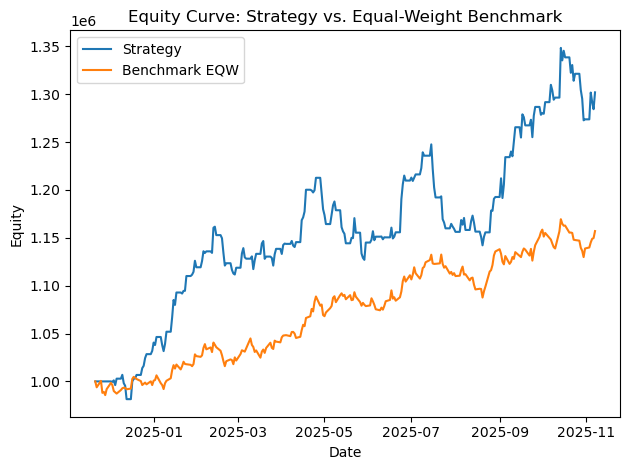

In [25]:
# Holdings log table
holdings_df = pd.DataFrame(holdings_history)
#display_dataframe_to_user("每周持仓（基于上一周周度回报选取TOP3）", holdings_df)

# Trade log table
trades_df = pd.DataFrame(trade_log)
# display_dataframe_to_user("交易日志", trades_df)

# 8) Plot equity curves
plt.figure()
plt.plot(equity_curve.index, equity_curve.values, label="Strategy")
plt.plot(bench_equity.index, bench_equity.values, label="Benchmark EQW")
plt.legend()
plt.title("Equity Curve: Strategy vs. Equal-Weight Benchmark")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.tight_layout()
plt.show()